In [1]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import operator,json, re, itertools 
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
# from wordcloud import WordCloud 
pd.options.display.max_colwidth = 300
import seaborn as sns
import config
data_root= config.DATA_ROOT
tqdm.pandas()
# import collect_tweets

In [2]:
df=pd.read_pickle(data_root+'tweets-priv.pkl')
print("# of privacy related tweets: {}\n# of unique users who tweeted:{}".format(len(df), len(df.author_id.unique())))

# of privacy related tweets: 216667
# of unique users who tweeted:90579


In [3]:
user_df = pd.read_pickle(data_root+'users-en-unique.pkl')
print('total # of users', len(user_df))

total # of users 1698096


In [4]:
uids = set(user_df.index)
df['author_group'] = df.progress_apply(lambda row: user_df.loc[row.author_id].user_group if row.author_id in uids else 'Unknown', axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216667/216667 [00:31<00:00, 6855.93it/s]


In [5]:
'''Number of tweets posted across groups'''
df.groupby('author_group').text.count().sort_values(ascending=True)
# print(df.groupby('author_group').text.count().sort_values(ascending=True).to_frame().to_latex())

author_group
personal            2254
techie              2492
academic            8197
news               12314
academic_techie    19170
personal_brand     20846
business_brand     44097
Unknown            53009
unknown            54288
Name: text, dtype: int64

In [6]:
deleted_users = set(df.author_id.unique()).difference(user_df.index)
print('# of users who tweeted sec-priv tweets but deleted their accounts:', len(deleted_users))
current_users = set(df.author_id).intersection(user_df.index)
print('# of users who tweeted sec-priv tweets and have their accounts:', len(current_users))
user_df=user_df.loc[list(current_users)]

# of users who tweeted sec-priv tweets but deleted their accounts: 26772
# of users who tweeted sec-priv tweets and have their accounts: 63807


In [7]:
'''remove tweets from deleted users as per TOS'''
df=df[df.apply(lambda row: row.author_id in current_users, axis=1)]
df.shape

(163658, 25)

In [8]:
'''Number of tweets posted across groups after removing deleted profiles'''
df.groupby('author_group').text.count().sort_values(ascending=True)

author_group
personal            2254
techie              2492
academic            8197
news               12314
academic_techie    19170
personal_brand     20846
business_brand     44097
unknown            54288
Name: text, dtype: int64

In [9]:
df["created_at"] = pd.to_datetime(df["created_at"])

In [10]:
df['search_grp'] = df.apply(lambda tweet: 
                            'mention' if tweet.search_term.startswith('@') \
                            else ('hashtag' if tweet.search_term.startswith('#') else 'other'), axis=1)

In [11]:
'''Parse the entities in a tweet object'''

def singleQuoteToDoubleQuote(singleQuoted):
        '''
        convert a single quoted string to a double quoted one
        Args:
            singleQuoted(string): a single quoted string e.g. {'cities': [{'name': "Upper Hell's Gate"}]}
        Returns:
            string: the double quoted version of the string e.g. 
        see
           - https://stackoverflow.com/questions/55600788/python-replace-single-quotes-with-double-quotes-but-leave-ones-within-double-q 
        '''
        cList=list(singleQuoted)
        inDouble=False;
        inSingle=False;
        for i,c in enumerate(cList):
            #print ("%d:%s %r %r" %(i,c,inSingle,inDouble))
            if c=="'":
                if not inDouble:
                    inSingle=not inSingle
                    cList[i]='"'
            elif c=='"':
                inDouble=not inDouble
        doubleQuoted="".join(cList)    
        return doubleQuoted
    
def parse_entity(row):
    if isinstance(row.entities, str):
        try:
            return json.loads(singleQuoteToDoubleQuote(row.entities).replace(u'\\xa0', u' '))
        except Exception as e:
            print(row.name, e)
            return {}
    else: 
        return {}
df['entities_parsed']= df.progress_apply(lambda row: parse_entity(row), axis=1)
# parse_entity(df.loc['1470058531546148880'])

 85%|██████████████████████████████████████████████████████████████████████████████████████████████                | 139904/163658 [00:06<00:00, 37854.45it/s]

1470755533770694661 Expecting ',' delimiter: line 1 column 763 (char 762)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163658/163658 [00:06<00:00, 24561.35it/s]


In [12]:
keys = df.apply(lambda row: list(row.entities_parsed.keys()), axis=1)
keys=list(itertools.chain.from_iterable(keys.values))
len(keys),set(keys)

(104257, {'annotations', 'cashtags', 'hashtags', 'mentions', 'urls'})

In [13]:
df['urls'] = df.apply(lambda row: [urlparse(url['expanded_url']).netloc for url in row.entities_parsed['urls']] \
                      if 'urls' in row.entities_parsed else [], axis=1)
df['hashtags'] = df.apply(lambda row: [hashtag['tag'] for hashtag in row.entities_parsed['hashtags']] \
                      if 'hashtags' in row.entities_parsed else [], axis=1)
df['anno_type'] = df.apply(lambda row: [a['type'] for a in row.entities_parsed['annotations']] \
                      if 'annotations' in row.entities_parsed else [], axis=1)
df['anno_text'] = df.apply(lambda row: [a['normalized_text'] for a in row.entities_parsed['annotations']] \
                      if 'annotations' in row.entities_parsed else [], axis=1)
df['mentions'] = df.apply(lambda row: [m['username'] for m in row.entities_parsed['mentions']] \
                      if 'mentions' in row.entities_parsed else [], axis=1)

In [14]:
def entity_stat(df, common=5):
    print('Number of tweets with url(s):', len(df[df.apply(lambda row: len(row.urls)>0, axis=1)]))
    print('Number of tweets with hashtag(s):', len(df[df.apply(lambda row: len(row.hashtags)>0, axis=1)]))
    print('Number of tweets with annotations(s):', len(df[df.apply(lambda row: len(row.anno_type)>0, axis=1)]))
    print('Number of tweets with mention(s):', len(df[df.apply(lambda row: len(row.mentions)>0, axis=1)]))
    print()
    mentions = list(itertools.chain.from_iterable(df.mentions.values))
    tags=list(itertools.chain.from_iterable(df.hashtags.values))
    urls=list(itertools.chain.from_iterable(df.urls.values))
    anno_type=list(itertools.chain.from_iterable(df.anno_type.values))
    anno_text=list(itertools.chain.from_iterable(df.anno_text.values))
    print('urls: {}, unique:{}, most_common:{}'.format(len(urls), len(set(urls)), Counter(urls).most_common(common)))
    print('mentions: {}, unique:{}, most_common:{}'.format(len(mentions), len(set(mentions)), Counter(mentions).most_common(common)))
    print('tags: {}, unique:{}, most_common:{}'.format(len(tags), len(set(tags)), Counter(tags).most_common(common)))
    print('anno_type: {}, unique:{}, most_common:{}'.format(len(anno_type), len(set(anno_type)), Counter(anno_type).most_common(common)))
    print('anno_text: {}, unique:{}, most_common:{}'.format(len(anno_text), len(set(anno_text)), Counter(anno_text).most_common(common)))

In [15]:
entity_stat(df , common=10)

Number of tweets with url(s): 40541
Number of tweets with hashtag(s): 41776
Number of tweets with annotations(s): 6666
Number of tweets with mention(s): 15245

urls: 50868, unique:3020, most_common:[('twitter.com', 11127), ('bit.ly', 8833), ('ow.ly', 6447), ('buff.ly', 2516), ('hubs.ly', 1440), ('gag.gl', 897), ('stwb.co', 858), ('okt.to', 799), ('goo.gl', 772), ('lnkd.in', 593)]
mentions: 22541, unique:7879, most_common:[('ZDNet', 226), ('EdTech_K12', 220), ('CIOonline', 206), ('InfosecurityMag', 205), ('ITProPortal', 175), ('NTTComSec_UK', 168), ('helpnetsecurity', 161), ('SearchSecurity', 160), ('CSOonline', 150), ('MdMisi', 131)]
tags: 144506, unique:10328, most_common:[('BYOD', 33591), ('security', 12834), ('cybersecurity', 5280), ('byod', 4103), ('infosec', 4082), ('mobile', 3653), ('privacy', 1553), ('mobilesecurity', 1463), ('IoT', 1444), ('Cybersecurity', 1401)]
anno_type: 8125, unique:5, most_common:[('Organization', 3343), ('Person', 1790), ('Product', 1606), ('Place', 1183)

In [16]:
# t=df[df.apply(lambda row: 'twitter.com' in row.urls[0] if row.urls else False, axis=1)]
# pd.options.display.max_colwidth=390
# t[['text']]
df.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'senti', 'topic',
       'text_clean_topic', 'text_clean_senti', 'topic_cos', 'topic_con',
       'author_group', 'search_grp', 'entities_parsed', 'urls', 'hashtags',
       'anno_type', 'anno_text', 'mentions'],
      dtype='object')

In [17]:
def get_tweet_type(tweet):
    for url in tweet.urls:
        if 'twitter.com' in url:
            return 'quote'
    if int(tweet.name)!=tweet.conversation_id:
        return 'reply'
    return 'novel'

df['tweet_type'] = df.apply(lambda tweet: get_tweet_type(tweet), axis=1)

In [18]:
df.groupby('tweet_type').text.count()

tweet_type
novel    134332
quote     11023
reply     18303
Name: text, dtype: int64

df.to_pickle(data_root+'tweets-priv-processed.pkl')## Who tweeted? Find user groups

In [19]:
df[df.author_group!='unknown'].groupby(['author_group', 'tweet_type']).text.count().sort_values(ascending=False).to_frame().head(10)

,,text
author_group,tweet_type,
business_brand,novel,37210
personal_brand,novel,17838
academic_techie,novel,15710
news,novel,11315
academic,novel,6078
business_brand,quote,5697
academic_techie,reply,2913
academic,reply,2000
techie,novel,1964


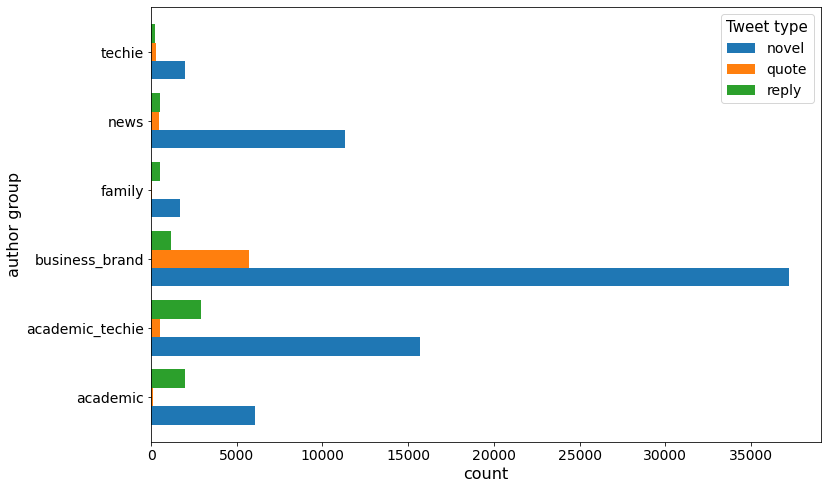

In [131]:
df[df.author_group!='unknown'].groupby(['author_group', 'tweet_type']).text.count().unstack().plot(kind='barh', width=.8, figsize=(12,8))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('count', fontsize=16)
plt.ylabel('author group', fontsize=16)
plt.legend(title="Tweet type", title_fontsize=15, fontsize=14, fancybox=True)
plt.show()

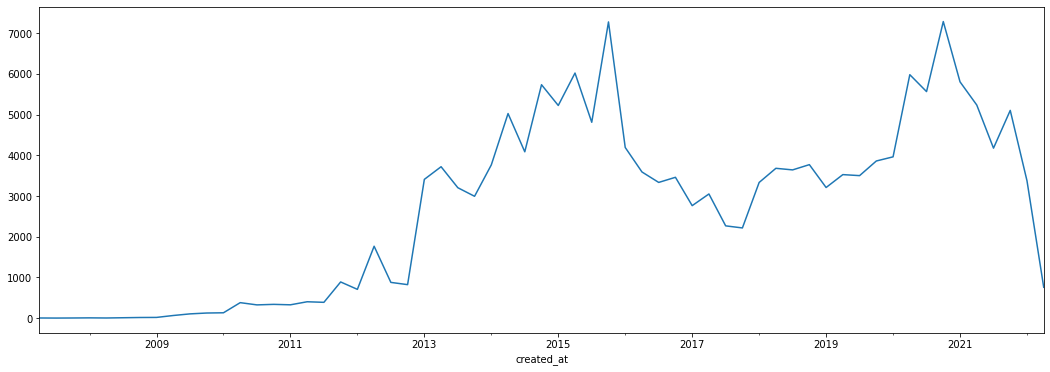

In [132]:
plt.figure(figsize=(18,6))
df.reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot()
plt.title('')
plt.show()

In [20]:
df.to_pickle(data_root+'tweets-priv-processed.pkl')

## Tweet sentiment

In [56]:
# def remove_comp(senti):
#     if 'compound' in senti:
#         senti.pop('compound')
#     return senti
# df['senti2'] = df.apply(lambda tweet: remove_comp(tweet.senti), axis=1)
# df['senti2'] = df.apply(lambda tweet: max(tweet.senti2.items(), key=operator.itemgetter(1))[0], axis=1)

In [57]:
df.groupby('senti').text.count()

senti
negative      7309
neutral     148082
positive      8267
Name: text, dtype: int64

In [58]:
df.groupby(['tweet_type','senti']).text.count()#.sort_values(ascending=False)

tweet_type  senti   
novel       negative      5651
            neutral     121958
            positive      6736
quote       negative       193
            neutral      10318
            positive       499
reply       negative      1465
            neutral      15806
            positive      1032
Name: text, dtype: int64

In [59]:
df[df.senti=='negative'].groupby(['author_group']).text.count().sort_values(ascending=False)

author_group
unknown           3545
business_brand    1327
academic_techi     823
personal_brand     579
news               451
academic           413
techie             171
Name: text, dtype: int64

In [60]:
neg_df = df[df.senti=='negative']

In [29]:
sample1 = pd.read_excel('priv-tweets-neg-sample1.xls')
sample1.tweetid = sample1.tweetid.astype(str)
sample1.set_index('tweetid', inplace=True)

In [30]:
df.loc[(set(sample1.index).intersection(set(df[df.senti=='negative'].index)))].sample(10)[['text']]

/var/folders/q5/tcs66y_j6z1bcz8ffp7_1m4r0000gq/T/ipykernel_55137/1178873254.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df.loc[(set(sample1.index).intersection(set(df[df.senti=='negative'].index)))].sample(10)[['text']]


,text
tweetid,
388933694498406400,No Recourse for Girls Harassed by Transgender Bully http://t.co/XI0FlCUhAb CO girls' privacy jeopardized by one gender confused moron=wrong
25920117445,I'm truly horrified by the circumstances of this young Rutgers student's invasion of privacy and subsequent suicide. http://bit.ly/bKaQBj
27787390340833280,"Teacher Punished for Reporting Violent 7-Year-Old: http://abcn.ws/eP17QU. Did she violate the student's privacy, or do the right thing?"
1455170658371977226,@CheetahJim1 @ProFootballTalk Not saying it's right to violate one's privacy but where were y'all when Linda Tripp was violating Monica Lewinski? People get violated by the system every day. Your typical college rape of a student by a professor involves far more violation than poor millionaire...
1337484131928862727,This is why I get mad when edtech or tech platforms get applauded \n\nNo one EVER asks what the fuck is going on in schools with privacy \n\nAnd let me tell you it is a mess because half the staff don’t know and the other half are wannabe prison guards https://t.co/GRkU0cBfHH
1122934665122320384,A student cleared of rape when his accuser’s text messages proved his innocence said this morning that rape suspects deserve the same right to privacy as victims https://t.co/rt13k0DI34
1025695617048301568,"@BostonDotCom WTF? This is disgusting. She's a student that work hard to get into college and she gets target b/c she a person of color and they're worried about the ""privacy laws"" after this young woman got humiliated for doing nothing wrong. Get the hell out here with that BS."
180695154313805824,"Dharun Ravi, ex Rutgers Univ student was found guilty on charges of invasion of privacy, but not guilty charges of bias intimidation"
9293828456,"Absolutely horrifying: ""School used student laptop webcams to spy on them at school and at home"" http://bit.ly/apfgRf #privacy"


In [31]:
df[df.senti=='negative'].sample(10)[['text']]

,text
tweetid,
101695842209107968,Court sides with college accused of snooping on student’s email account http://e74.us/8w #privacy RT @internetcases &lt; Unencrypted = insecure
344785106378043393,BYOD &amp; the implications for the IT team http://t.co/SM6MAuiqkB #tech #news #BYOD #mobile #IT #security
941678592970379265,See how @usedgov now investigating @MoskowitzEva &amp; @SuccessCharters for violations of student privacy #FERPA @MarkTreyger718 @Parents4Privacy @FatimaFarax @NYCKidsPAC @jbelluck @CoreyinNYC @Dromm25 @ChalkbeatNY @NYDNBenChapman @katetaylornyt https://t.co/d0PYXySLy9
289560706506969088,School privacy policies are dangerous. Coworker was not allowed to learn name of student who fractured son's skull due to privacy policy.
1336323095565459461,"@susanoha Some edtech is great and others are an abomination, digiLEARN is selling the abomination edtech that is expensive, sunders privacy and harms children. https://t.co/WYSvU3mEM8"
1325974559506522112,"@PublixHelps The chairs to the right in the grocery store was where 2 people in the pharmacy, first a student and then the pharmacist, tried to give me the flu vaccine. I refused because this is unacceptable. No privacy. Pathetic pt care! https://t.co/t4O0wn4MPf"
854077533104427008,MT @TeriGRight: #CommonCore intrusive data mining threatens student privacy! #KeepYourPromise #StopCommonCore https://t.co/6xyB74ntJa #PJNET
1101672288985014272,The latest Hecht Hyperborean! https://t.co/YJKNCaAxez Thanks to @catacalypto @twmillar @nevesytrof #privacy #edtech
310032618819297281,"Allure of ""21st-century technology"" masks privacy-undermining agenda of those allergic to..parental autonomy. http://t.co/gMGlL2xZk4"


### Topics

In [61]:
priv_topics = [line.split(':')[1] for line in open('priv-tweet-topics.txt')]
for pt in range(len(priv_topics)):
    print(pt, priv_topics[pt].strip())

0 gauge pseudonym tyranny culprit sarcasm ludicrous nefarious pedophile disingenuous fwiw
1 edtech cybersecurity dfir skillsgap nlproc ingramtechsol systemsthinke stcenturyskill thecybersecurityplace cybint
2 datum protect sotu schoolprivacyzone paigekowalski datadrivesresult rachelbarrer takectrl replukemesser benjaminbherold
3 username share talk story daily event awesome tune david advisor
4 school lifeleader schoolchildren safeschool studentvoice chooseprivacy schooldistrict coetail powerschool indyschool
5 security byod mobile device enterprisesecurity byodsecurity fiercemobileit securityrisk dellsecurity symantec
6 privacy student news washington priva myname privac stud studentright priv
7 facebook internship flaw austrian lose harvard expose highlight messenger cancel
8 conclude cpdp myriad minefield txcto asugsv sotn bettertogether nuisance rundown
9 neighborhood georgetown auburn nazi chattanooga tulsa knife sixth uconn franklin


In [33]:
interesting_topics=[0, 1,2 ,3,4,6]
# 0: talks about tyranny of EdTech
# 1: ingramtechsol, thecybersecurityplace, cybint-->general cybersecurity, 
# 2: names of politicians, journalists who talk about (privacy?) policy
# 3: news, articles, announcements, some about how to prevent security/privacy issues 
# 4: similar to 0
# 5: about BOYD, ignore

In [58]:
df.groupby('topic').text.count().sort_values(ascending=False)#.head(10)

topic
 6    104699
 5     37108
 1     12735
 3      6447
 2      1205
 4       702
-1       699
 7        48
 0        12
 9         3
Name: text, dtype: int64

### Sample negative tweets for each topic for manual annotation 

In [63]:
# neg_df = df[df.senti=='negative']
# neg_df['link']=neg_df.apply(lambda r: 'http://twitter.com/u/status/{}'.format(r.name), axis=1)
# neg_df.groupby('topic').text.count().sort_values(ascending=False).head(10)

In [64]:
# neg_df[neg_df.topic<5][['text', 'link']].to_excel('neg-tweet-[0-4].xls')

In [62]:
# tdf= df[df.apply(lambda row: row.topic==5 and 'edtech' in row.text.lower(), axis=1)]
# print(len(tdf))
# tdf[['text']].to_excel('neg-tweet-5.xls')
# tdf.sample(np.min([10,len(tdf)]))[['text', 'topic','topic_cos','created_at']]

### remove duplicate tweets

In [204]:
# topic_6 = pd.read_excel('neg-tweet-6.xlsx')#pd.concat([pd.read_excel('neg-tweet-6.xlsx').iloc[:1753], pd.read_excel('neg-tweet-6-no-dup.xlsx')[1753:]])
# print(topic_6.shape)
# dups = [line.strip() for line in open('duplicates.txt')][0].split(',')
# dups=list(filter(None, dups))
# dup_tweets = []
# for dup in dups:
#     dup_tweets += list(topic_6[topic_6.apply(lambda row: dup.strip().lower() in row.text.lower() and \
#                                              (isinstance(row.Code1, float) or len(row.Code1)==0), axis=1)].index)
# len(dup_tweets)
# topic_6[topic_6.apply(lambda row: ' rfid ' in row.text.lower(), axis=1)] 

In [66]:
# no_dup=topic_6.drop(index=dup_tweets)
# print(no_dup.shape)
# no_dup[['text','Code1', 'link']].to_excel('neg-tweet-6-final.xlsx')

### Analyze labelled tweets

In [21]:
def get_tfidf_top_features(documents,n_top=10, max_df=.3, min_df=5):
    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(documents)
    importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())
    return tfidf_feature_names[importance[:n_top]]


In [29]:
# labled_df = pd.concat([pd.read_csv('neg-tweet-6-final.csv',  sep=',', encoding = "utf-8"),
#                       pd.read_csv('neg-tweet-(0-4).csv',  sep=',', encoding = "utf-8")])
# labled_df['tweetid'] = labled_df.apply(lambda row: row.link.split('/')[-1], axis=1)
# labled_df = labled_df[labled_df.apply(lambda row: isinstance(row.Code, str) and len(row.Code.strip())>2, axis=1)]

# df= pd.read_csv('neg-tweet-5.csv',  sep=',', encoding = "utf-8")
# df['tweetid']=df.tweetid.astype(str)
# labled_df=pd.concat([labled_df, df])

# labled_df.set_index('tweetid', inplace=True)
# print(labled_df.shape)
# labled_df=labled_df[['text', 'Code']]
# labled_df.to_csv('all-sec-priv-labeled-tweets.csv', encoding='utf-8')
# labled_df.tweetid=labled_df.tweetid.astype(str)
# labled_df.set_index('tweetid', inplace=True)

# ldf=df.loc[labled_df.index]
# ldf['code'] = labled_df.code
# ldf.shape
# ldf.to_pickle('all-sec-priv-labeled-tweets.pkl')
# ldf.to_csv('all-sec-priv-labeled-tweets.csv', encoding='utf-8')

In [30]:
labled_df = pd.read_pickle('all-sec-priv-labeled-tweets.pkl')
print(labled_df.shape)
labled_df.head(2)

(4648, 34)


,author_id,text,created_at,geo,retweets,replies,likes,quote_count,lang,conversation_id,...,author_group,search_grp,entities_parsed,urls,hashtags,anno_type,anno_text,mentions,tweet_type,code
tweetid,,,,,,,,,,,,,,,,,,,,,
1301656105626476546,1296874226100494338,"I’m a teacher. If I mishandled one student, one time, I’d no longer have a job &amp; no longer be able to work w kids. &amp; Yet cops kill &amp; abuse over &amp; over again, while keeping their jobs, their privacy, &amp; their pay. \nIt amazes me that #defundthepolice is controversial or political",2020-09-03 22:59:33+00:00,NaN,0,0,0,0,en,1301656105626476546,...,unknown,other,{},[],[],[],[],[],novel,other
1312039409689255936,705983975957745664,"‘It Feels Like an Invasion of Privacy’ ➡️ THAT'S BECAUSE IT IS. \n\nIf one's assessment materials (i.e., an exam) are easy enough to game that you can catch cheating by surveillance software, you're not educating in the first place.\n\nhttps://t.co/IYWN5qeFaO",2020-10-02 14:39:06+00:00,NaN,0,0,0,0,en,1312039409689255936,...,academic,other,"{'urls': [{'start': 232, 'end': 255, 'url': 'https://t.co/IYWN5qeFaO', 'expanded_url': 'https://www.nytimes.com/2020/09/29/style/testing-schools-proctorio.html', 'display_url': 'nytimes.com/2020/09/29/sty…'}]}",[www.nytimes.com],[],[],[],[],novel,privacy-generic


In [31]:
labled_df.groupby('code').text.count().sort_values(ascending=False)

code
other-student-privacy    864
privacy-specific         725
other-privacy            574
article                  494
other                    424
privacy-generic          406
policy                   262
privacy incident         190
info_brand               131
tech_brandi               86
edtech-generic            76
edtech-ques               45
edtech ban                 4
Name: text, dtype: int64

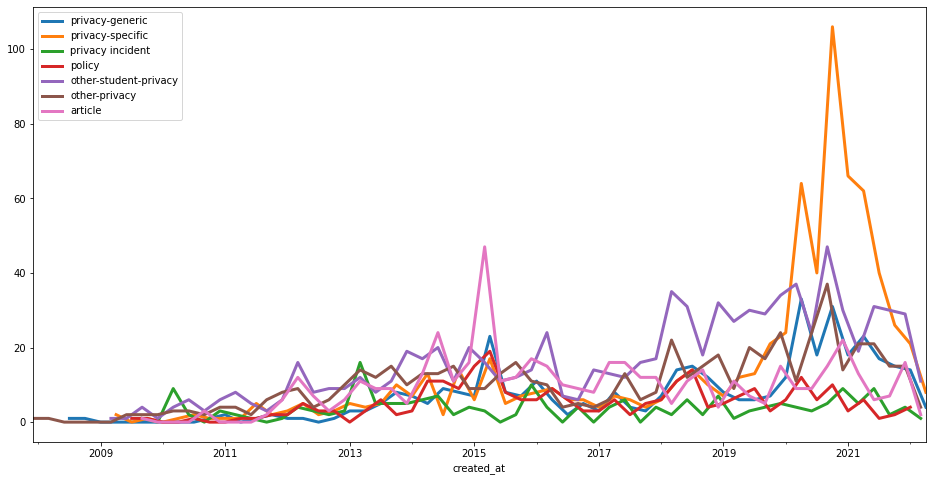

In [144]:
for code in ['privacy-generic', 'privacy-specific', 'privacy incident', 'policy', 'other-student-privacy', 'other-privacy', 'article']:
    labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label=code, linewidth=3, figsize=(16,8))
plt.legend()

In [32]:
labled_df[labled_df.author_group!='unknown'].groupby(['code', 'author_group']).text.count().sort_values(ascending=False).tail(20)

code                   author_group   
article                personal           6
                       techie             5
edtech-ques            academic           5
privacy incident       personal           5
edtech-ques            business_brand     5
other-student-privacy  techie             4
tech_brandi            news               4
                       academic           3
                       techie             3
edtech ban             academic_techie    2
privacy incident       techie             2
edtech-generic         personal           2
edtech-ques            personal_brand     2
info_brand             academic           2
                       techie             2
privacy-generic        techie             1
policy                 techie             1
edtech-ques            news               1
                       personal           1
info_brand             news               1
Name: text, dtype: int64

In [40]:
'''who tweeted generic and specific privacy concerns'''
print(labled_df[(labled_df.author_group!='unknown') &((labled_df.code=='privacy-generic') | (labled_df.code=='privacy-specific'))].groupby(['code', 'author_group']).text.count().to_frame().to_latex())

\begin{tabular}{llr}
\toprule
                 &        &  text \\
code & author\_group &       \\
\midrule
privacy-generic & academic &    33 \\
                 & academic\_techie &    86 \\
                 & business\_brand &    29 \\
                 & news &     7 \\
                 & personal &     6 \\
                 & personal\_brand &    25 \\
                 & techie &     1 \\
privacy-specific & academic &    80 \\
                 & academic\_techie &   125 \\
                 & business\_brand &    44 \\
                 & news &    16 \\
                 & personal &    13 \\
                 & personal\_brand &    34 \\
                 & techie &    21 \\
\bottomrule
\end{tabular}



/var/folders/1p/0rwj4hf522b5v3bzw33bsdqw0000gn/T/ipykernel_86551/2715073796.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(labled_df[(labled_df.author_group!='unknown') &((labled_df.code=='privacy-generic') | (labled_df.code=='privacy-specific'))].groupby(['code', 'author_group']).text.count().to_frame().to_latex())


In [39]:
d=dict()
common=set()
for t in ['privacy-generic', 'privacy-specific']:
    for a in ['academic', 'academic_techie', 'business_brand', 'personal_brand', 'personal','news','techie']:
        text = labled_df[(labled_df.author_group==a) & (labled_df.code==t)].text_clean_topic.values
        if len(text) > 1:
            tfidf = get_tfidf_top_features(text, n_top=10, max_df=.8, min_df=1)
            print('{}:  {}'.format(t+','+a, ', '.join(tfidf)))
    print()
            # d[t+','+a]= tfidf
            # if len(common)==0:
            #     common.update(set(tfidf))
            # else:
            #     common=common.intersection(tfidf)
# for k in d.keys():
#     print('{}:  {}'.format(k, ', '.join(d[k])))
    #print('\t\t{}'.format(set(d[k]).difference(common)))
    

privacy-generic,academic:  username, privacy, student, edtech, surveillance, datum, law, time, platform, issue
privacy-generic,academic_techie:  username, privacy, student, edtech, datum, school, surveillance, issue, app, teacher
privacy-generic,business_brand:  privacy, username, student, datum, school, edtech, byod, surveillance, onlinesafety, security
privacy-generic,personal_brand:  privacy, username, student, datum, edtech, eddata, teacher, concern, school, issue
privacy-generic,personal:  username, student, expectation, accountability, understand, secure, threaten, pjnet, keepyourpromise, intrusive
privacy-generic,news:  student, mooc, loss, major, drawback, blow, surveillance, username, people, rep

privacy-specific,academic:  username, student, privacy, issue, datum, surveillance, concern, school, violation, teacher
privacy-specific,academic_techie:  username, privacy, student, edtech, school, issue, security, google, surveillance, app
privacy-specific,business_brand:  privacy,

/Users/admin/work/edtech-scrape/edenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Visibility

In [43]:
'''Were a few people overly representitive?'''
print('unique authors: ', len(labled_df.author_id.unique()))
labled_df.groupby(['author_id']).text.count().describe()#sort_values(ascending=False).head(10)

unique authors:  3577


count    3577.000000
mean        1.299413
std         2.248435
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        76.000000
Name: text, dtype: float64

In [53]:
labled_df.groupby(['author_id']).text.count().sort_values(ascending=False).head(22)

author_id
36991951              76
118530377             59
19895837              45
224059040             37
2968343710            33
216928966             24
2299828074            23
90749008              22
15694680              17
182539117             17
2533386684            16
768098863395827712    15
6505892               15
739293                11
3959010562            11
7044082               11
26744205              11
16946286              11
32866389              11
2586135432            10
4256298574            10
15740610              10
Name: text, dtype: int64

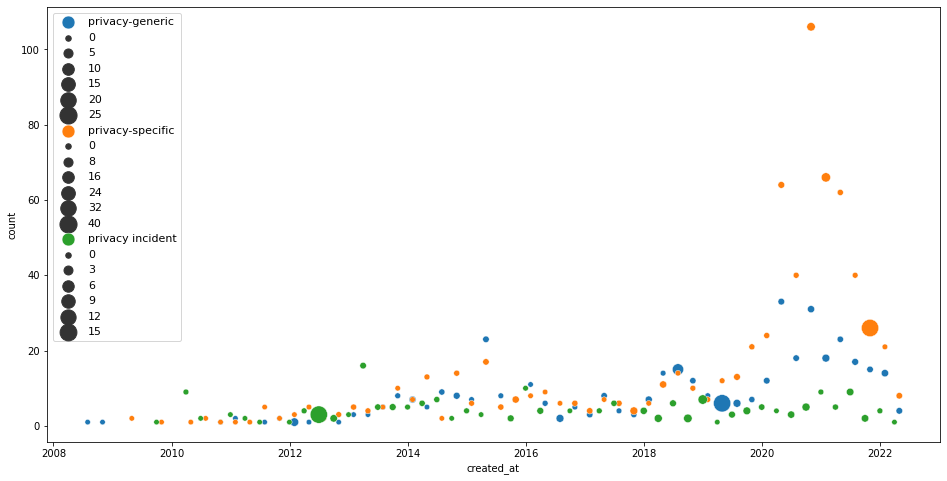

In [40]:
'''Retweets and likes on tweets expressing generic and specific concerns'''
plt.figure(figsize=(16, 8))
markers={'privacy-generic':'D', 'privacy-specific': 'o', 'privacy incident':'*'}
g=labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='6M'))
for code in ['privacy-generic', 'privacy-specific', 'privacy incident']:
    g = labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M'))#.text.count().plot(label=code, marker="o", markersize=15, linestyle='none')

    gdf = g.text.agg(['count'])
    gdf['retweets'] = g.retweets.mean()
    gdf['likes'] = g.likes.mean()
    gdf.reset_index(inplace=True)
    sns.scatterplot(
        data=gdf, x='created_at', y='count',  size="retweets", label=code, marker='o',#markers[code],
        sizes=(30, 300), hue_norm=(0, 7)#, legend="full"
    )

plt.legend(title="", title_fontsize=12, fontsize=11, fancybox=True)
plt.show()

In [108]:
labled_df.groupby('code').retweets.mean().sort_values(ascending=False)

code
edtech ban               232.750000
privacy-specific           3.914483
privacy-generic            1.820197
other-student-privacy      1.500000
other-privacy              1.465157
article                    1.338057
info_brand                 1.244275
other                      0.981132
privacy incident           0.978947
policy                     0.977099
tech_brandi                0.860465
edtech-generic             0.578947
edtech-ques                0.400000
Name: retweets, dtype: float64

In [102]:
labled_df[labled_df.code=='edtech ban'][['text', 'retweets', 'likes']]

,text,retweets,likes
tweetid,,,
1363966363602051074,"So I've been stuck on the camera policy for my Zoom classes. I totally get the worries about student privacy and invasiveness. But I also know that my teaching gets radically worse when I'm facing mostly all black squares. So this time, I tried complete honesty.\n\nReport-thread:",930,4782
1207861674264412160,@33heupel Depending on what you can use in regards to Ss data privacy @Flipgrid could be a great tool here. #ditchbook,0,4
1249694208471863297,"@Garreth_Wigg @GoogleForEdu @MicrosoftEDU @AppleEDU yes they do have the same problem, a lot of these systems and services are restricted in our public schools. In the private sector however it is not so restrictive. new data privacy laws have had wide sweeping implications on how we obtain perm...",0,0
1357788885015789570,"So sad (and a bit surprised) that we are not able to suggest that our teachers use @Flipgrid anymore, since they won't sign our state student data privacy agreement. We love Flipgrid!💚",1,4


In [103]:
labled_df.groupby('code').likes.mean().sort_values(ascending=False)

code
edtech ban               1197.500000
privacy-specific            9.673103
privacy-generic             5.529557
other-student-privacy       5.171296
other                       4.577830
other-privacy               3.869338
edtech-generic              2.157895
policy                      1.801527
privacy incident            1.710526
info_brand                  1.618321
article                     1.566802
tech_brandi                 1.244186
edtech-ques                 1.222222
Name: likes, dtype: float64

In [102]:
labled_df.groupby('author_id').text.count().sort_values(ascending=False).head(10)

author_id
36991951      76
118530377     59
19895837      45
224059040     37
2968343710    33
216928966     24
2299828074    23
90749008      22
15694680      17
182539117     17
Name: text, dtype: int64

### Keywords in each group

array(['username', 'privacy', 'student', 'edtech', 'datum',
       'surveillance', 'school', 'issue', 'eddata', 'teacher', 'concern',
       'app', 'kid', 'security', 'parent', 'education', 'bad', 'protect',
       'child', 'online', 'tool', 'company', 'time', 'learn',
       'information'], dtype='<U17')

array(['username', 'privacy', 'student', 'school', 'surveillance',
       'edtech', 'security', 'datum', 'issue', 'software', 'invasion',
       'app', 'violation', 'google', 'concern', 'exam', 'policy', 'kid',
       'zoom', 'teacher', 'bad', 'online', 'violate', 'proctorio', 'feel'],
      dtype='<U20')

### Entities in each group

In [187]:
'''what edtech providers were mentioned most in privacy groups'''
def common_mentions(kw):
    mentions = labled_df[labled_df.code==kw].mentions
    mentions = list(itertools.chain.from_iterable(mentions))
    mentions = [m.lower() for m in mentions]
    print("unique mentions:", len(set(mentions)))
    mentions = Counter(mentions)
    print(mentions.most_common(10))
common_mentions('privacy-specific')
common_mentions('privacy-generic')

unique mentions: 129
[('goguardian', 8), ('chegg', 7), ('examsoft', 6), ('edpuzzle', 5), ('pearsonvue', 4), ('linkletter', 3), ('googleforedu', 3), ('coursehero', 3), ('chegghelp', 3), ('classdojo', 2)]
unique mentions: 32
[('zdnet', 1), ('danielharvey9', 1), ('kmp39', 1), ('jeremycyoung', 1), ('edmodo', 1), ('mikemcsharry', 1), ('eileenbelastock', 1), ('edtechdigest', 1), ('douglevin', 1), ('managedmethods', 1)]


In [175]:
'''what urls/domains are used for article group'''
urls = labled_df[labled_df.code=='article'].urls
urls

tweetid
1339974630698856448    []
199919127895351296     []
540992121952423936     []
672312661560848384     []
561143099498721280     []
                       ..
183562595104600066     []
200969939442610177     []
342299881228099584     []
605423600452124674     []
512007017008218112     []
Name: urls, Length: 494, dtype: object

In [195]:
labled_df.senti

tweetid
1301656105626476546    negative
1312039409689255936    negative
570992748725194752     negative
1006594055432802305    negative
1352870101775654913    negative
                         ...   
245581393768366080     positive
245338142209605632      neutral
245238058423828480      neutral
245212511979319296      neutral
1024331454820446209     neutral
Name: senti, Length: 4648, dtype: object

In [49]:
x='@Schoology, @Schoolytics, @GoogleForEdu, @moodle, @MyPowerSchool, @CanvasLMS, @Educ_Technology, @EdTech_K12, @MerlynMind, @edXOnline, @DigitalPromise, @LearningAtScale, @edtechdigest, @edmodo, @ClassDojo, @Newsela, @quizizz, @blackboard, @edpuzzle, @PearDeck, @Flipgrid, @BookCreatorApp, @mergeedu, @BookCreatorApp, @Seesaw, @TeachFX, @udacity, @coursera, @udemy, @edXOnline, @MicrosoftEDU, @proctorio, @examity, @ProctortrackPro, @speedexam, @in_examonline, @MercerMettl, @Examus1, @ProctorU, @Verificient, @AIProctor, @ExamSoft, @conductexam, @ProctorExam, @PSIServicesLLC, @pearsonvue, @merittracsvc, @Civitaslearning, @DreamBox_Learn, @GoGuardian, @GuildEducation, @Instructure, @Chegg, @CreativeLive, @CourseHero, @Masterclass'
len(x.split(','))

56